## Exercise Set 2 for OSM 

### Dynamic Programming with John Stachurski

Exercises for the [OSM](https://bfi.uchicago.edu/osm) bootcamp dynamic programming section.

We will use the following libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

### Exercise 1

Consider the setting of the [stochastic optimal growth model](https://lectures.quantecon.org/py/optgrowth.html), with the same notation and same assumptions on the primitives $u$, $f$, $\beta$ and $\phi$. 

Let $\mathscr C$ be all continuous bounded functions on $\mathbb R_+$.

Let $\sigma \in \Sigma$ be any feasible policy and let $U$ be the operator from $\mathscr C$ to itself defined by

$$ Uw(y) = u(\sigma(y)) + \beta \int w(f(y - \sigma(y))z) \phi(dz) \qquad (y \in \mathbb R_+)$$

Prove that $U$ is a contraction mapping with respect to the supremum distance.  Argue that the unique fixed point of $U$ in $\mathscr C$ is $v_\sigma$.

("Argue" means provide a sketch of a proof that contains the key ideas, plus some intuition.  Or give a complete, formal proof, if you can.)

### Proof

The proof is in the 'Problem Set 2' pdf.

### Exercise 2

Notation and concepts continue from exercise 2.

Use the fact you proved in exercise 2, combined with piecewise linear interpolation method we used for the Bellman operator, to compute and plot good approximations of the value $v_\sigma$ of the policies

* $\sigma_1(y) = 0.95 y$
* $\sigma_2(y) = H(y) y$ where $H$ is the cdf of the lognormal $LN(0, 0.5)$ distribution.

For the latter use `scipy.stats.lognorm.cdf(y, 0.5)`

For the primitives, use the default specification in the `LogLinearOG` class from the [stochastic optimal growth model lecture](https://lectures.quantecon.org/py/optgrowth.html).

Plot your results, choosing grid and plotting dimensions to best illustrate the two functions.  Based on the plot alone, argue that neither of these policies is an optimal policy.

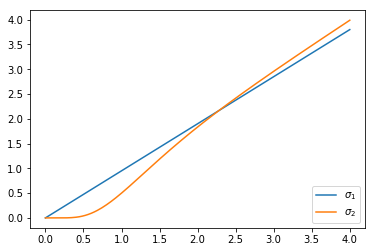

In [62]:
import numpy as np
from scipy.optimize import fminbound
import matplotlib.pyplot as plt
from scipy import stats

# I modify the Bellman Operator code to accept a fixed policy function as input:

def adj_bellman_operator(w, grid, beta, u, f, shocks, sigma_bar = 0, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    sigma_bar : function (optional)
        An optional fixed policy function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == # 
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        if sigma_bar == 0:
            c_star = fminbound(objective, 1e-10, y)
        else:
            c_star = sigma_bar(y)
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

    
# We also retain the LogLinearOG class:

class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)
    

#Now let us define a policy function
def sigma_1(y):
    return 0.95*y

def sigma_2(y):
    return stats.lognorm.cdf(y, 0.5)*y

# Just for fun, let's see what the policy functions look like:

plt.plot(grid, sigma_1(grid), label='$\sigma_1$')
plt.plot(grid, sigma_2(grid), label='$\sigma_2$')
plt.legend(loc='lower right')
plt.show()


In [63]:
# We continue as in the lecture:

lg = LogLinearOG()
# == Unpack parameters / functions for convenience
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star = lg.v_star

grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

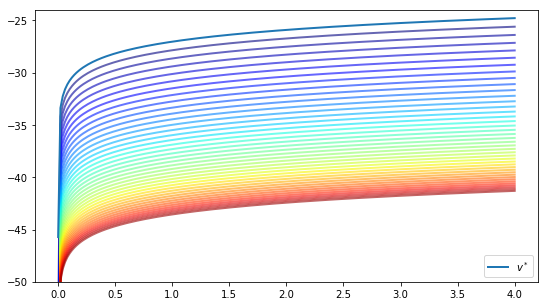

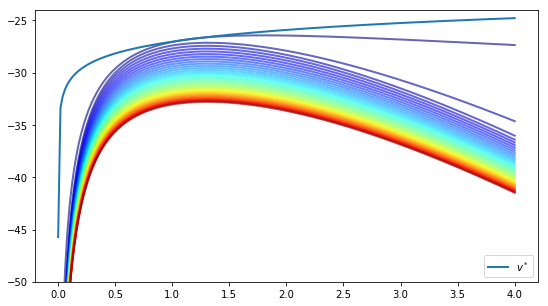

In [64]:
# Let's see how the functions converge with the adjusted Bellman Op
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-50, -24)
w = v_star(grid)
N = 40
for i in range(N):
    w_1 = adj_bellman_operator(w,
                         grid,
                         beta,
                         np.log,
                         lambda k: k**alpha,
                         shocks,
                         lambda y: sigma_1(y)
                            )
    ax.plot(grid, w_1, color=plt.cm.jet(i / N), lw=2, alpha=0.6)
    w = w_1
ax.plot(grid, v_star(grid), lw= 2, alpha=1 , label='$v^*$')
ax.legend(loc='lower right')
plt.show()

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-50, -24)
w = v_star(grid)
for i in range(N):
    w_2 = adj_bellman_operator(w,
                     grid,
                     beta,
                     np.log,
                     lambda k: k**alpha,
                     shocks,
                     lambda y: sigma_2(y)
                        )
    ax.plot(grid, w_2, color=plt.cm.jet(i / N), lw=2, alpha=0.6)
    w = w_2

#fig, ax = plt.subplots(figsize=(9, 5))
#ax.set_ylim(-35, -24)

ax.plot(grid, v_star(grid), lw= 2, alpha=1 , label='$v^*$')
ax.legend(loc='lower right')
plt.show()



In [ ]:
# Nice. (we can already see that neither is optimal)

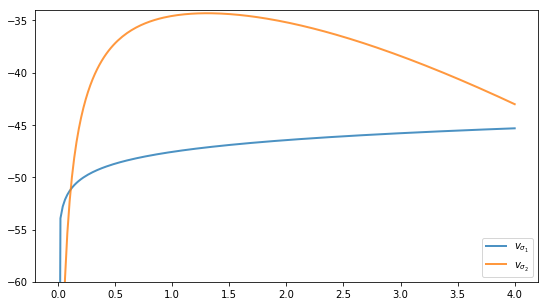

In [66]:
# And now, let us compare the two fixed point /converged value functions.

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-60, -34)
w = v_star(grid)

N = 400
for i in range(N):
    w_1 = adj_bellman_operator(w,
                         grid,
                         beta,
                         np.log,
                         lambda k: k**alpha,
                         shocks,
                         lambda y: sigma_1(y)
                            )
    w = w_1
ax.plot(grid, w_1, lw= 2, alpha= 0.8 , label='$v_{\sigma_1}$')


w = v_star(grid)
for i in range(N):
    w_2 = adj_bellman_operator(w,
                     grid,
                     beta,
                     np.log,
                     lambda k: k**alpha,
                     shocks,
                     lambda y: sigma_2(y)
                        )
    w = w_2
ax.plot(grid, w_2, lw= 2, alpha= 0.8 , label='$v_{\sigma_2}$') 

#fig, ax = plt.subplots(figsize=(9, 5))
#ax.set_ylim(-35, -24)

#ax.plot(grid, v_star(grid), lw= 2, alpha=1 , label='$v^*$')
ax.legend(loc='lower right')
plt.show()

Thus, even without the optimal $v^*$ in the picture, we can see that neither policy is optimal, since neither one dominates the other, ...

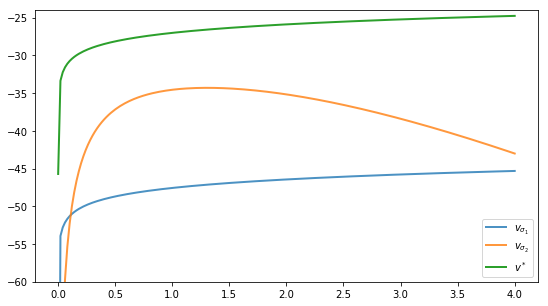

In [65]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-60, -24)
w = v_star(grid)

N = 500
i = 0 
error = 1
tol = 1e-6
while (i < N) and (error > tol):
    w_1 = adj_bellman_operator(w,
                         grid,
                         beta,
                         np.log,
                         lambda k: k**alpha,
                         shocks,
                         lambda y: sigma_1(y)
                            )
    error = sum(abs(w_1 - w))
    #if i - (i//50)*50 == 0:
     #   print(i)
    i += 1
    w = w_1
ax.plot(grid, w_1, lw= 2, alpha= 0.8 , label='$v_{\sigma_1}$')


w = v_star(grid)
i = 0
error = 1
while (i < N) and (error > tol):
    w_2 = adj_bellman_operator(w,
                     grid,
                     beta,
                     np.log,
                     lambda k: k**alpha,
                     shocks,
                     lambda y: sigma_2(y)
                        )
    error = sum(abs(w_1 - w))
    #if i - (i//50)*50 == 0:
     #   print(i)
    i += 1
    w = w_2
ax.plot(grid, w_2, lw= 2, alpha= 0.8 , label='$v_{\sigma_2}$') 

ax.plot(grid, v_star(grid), lw= 2, alpha=1 , label='$v^*$')
ax.legend(loc='lower right')
plt.show()

... and with direct comparison to $v^*$, both are far from optimal.


$\square$